In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [27]:
source('main.R')

data <- kaggle.house$loadData()

df.combined <- kaggle.house$getCombinedDataset(data$train, data$test)

trainset <- 
    df.combined %>% 
    filter(dataSource == "train") %>% 
    select(-dataSource)

trainset %>% nrow

[1] 1460

In [50]:
trainset.cat <- trainset %>% select(one_of(union(kaggle.house$getCategoricalColumnNames(.), "SalePrice")))
trainset.num <- trainset %>% select_if(is.numeric)

stopifnot(
    length(trainset.cat %>% select(-SalePrice)) + length(trainset.num) == length(trainset)
)

In [55]:
r2.SalePrice.vs.cat <- trainset.cat %>%
    gather(var.name, var.value, -SalePrice) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(SalePrice ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared')
    ) %>%
    select(var.name, r2) %>%
    arrange(desc(r2))

r2.SalePrice.vs.cat %>% filter(r2 > 0.09) %>% t

var.name,Neighborhood,ExterQual,KitchenQual,BsmtQual,PoolQC,Alley,GarageFinish,Foundation,MSSubClass,GarageType,⋯,BsmtFinType1,MasVnrType,Exterior2nd,Exterior1st,SaleType,SaleCondition,BsmtExposure,MiscFeature,FireplaceQu,MSZoning
r2,0.5455750,0.4773878,0.4565986,0.4537561,0.4486514,0.2854967,0.2672764,0.2563684,0.2463160,0.2066384,⋯,0.1925976,0.1878934,0.1538299,0.1527731,0.1372875,0.1354975,0.1304156,0.1146050,0.1131419,0.1075597


In [56]:
r2.SalePrice.vs.num <- trainset.num %>%
    gather(var.name, var.value, -SalePrice) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(SalePrice ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared')
    ) %>%
    select(var.name, r2) %>%
    arrange(desc(r2))

r2.SalePrice.vs.num %>% filter(r2 > 0.09) %>% t

var.name,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,X1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,X2ndFlrSF,OpenPorchSF
r2,0.62565189,0.50214865,0.41012394,0.38866676,0.37648109,0.36705687,0.31434385,0.28486041,0.27342162,0.25715139,0.23654768,0.22799961,0.21802254,0.14932027,0.12376260,0.10524408,0.10197408,0.09976516


In [82]:
?geom_histogram

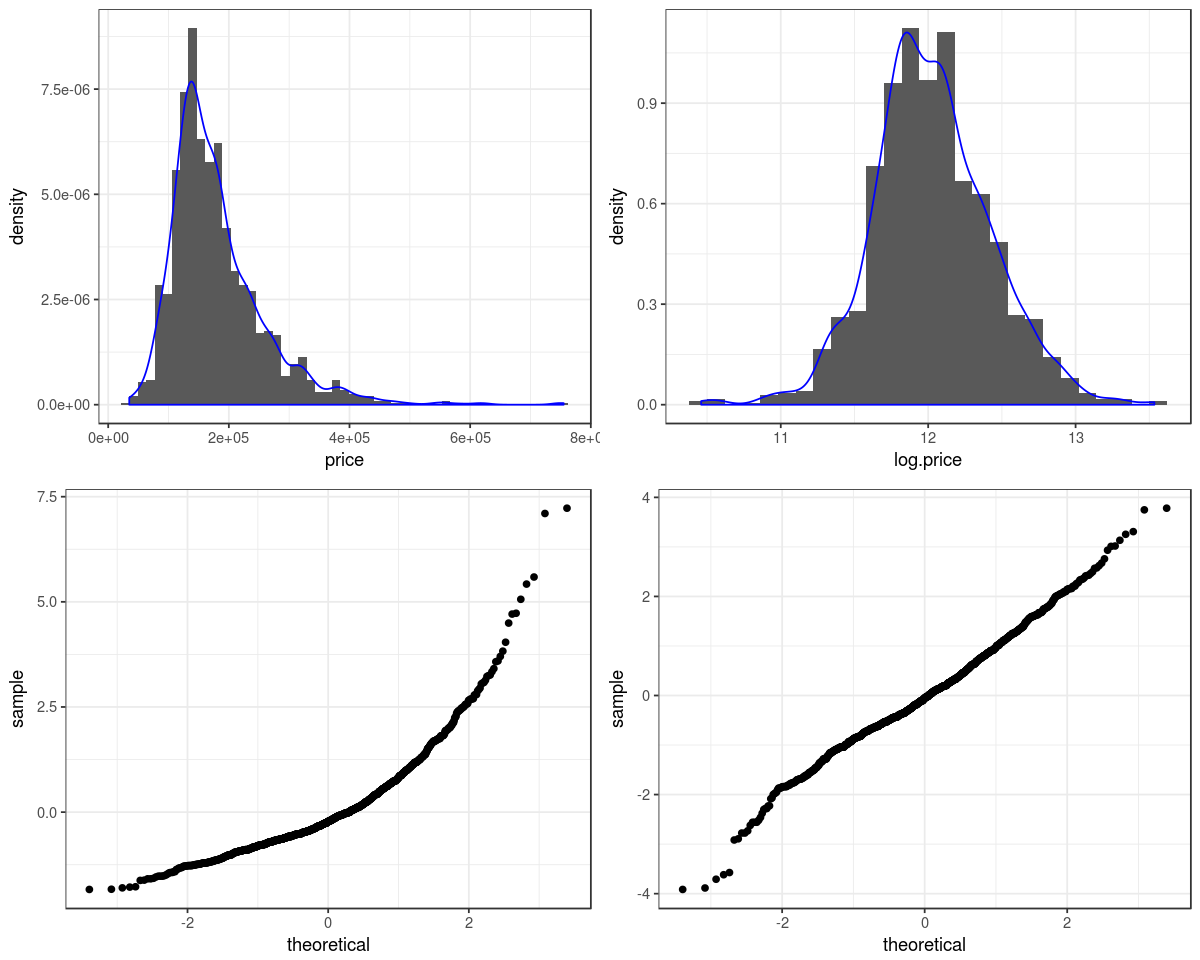

In [119]:
p1 <- trainset %>% 
    select(price=SalePrice) %>%
    ggplot(aes(price)) +
    geom_histogram(aes(y=..density..), binwidth=14e3) +
    geom_density(color="blue") +
    theme_bw()

p2 <- trainset %>% 
    mutate(log.price = log(SalePrice)) %>%
    ggplot(aes(log.price)) +
    geom_histogram(aes(y=..density..), binwidth=0.12) +
    geom_density(color="blue") +
    theme_bw()

qq1 <- trainset %>% 
    select(price=SalePrice) %>%
    mutate(price.norm = (price - mean(price)) / sd(price)) %>%
    ggplot() +
    geom_qq(aes(sample=price.norm)) +
    theme_bw()

qq2 <- trainset %>% 
    mutate(
        log.price = log(SalePrice),
        log.price.norm = (log.price - mean(log.price)) / sd(log.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=log.price.norm)) +
    theme_bw()

options(repr.plot.width = 10, repr.plot.height = 8)

grid.arrange(p1, p2, qq1, qq2, layout_matrix=rbind(c(1, 2), c(3, 4)))

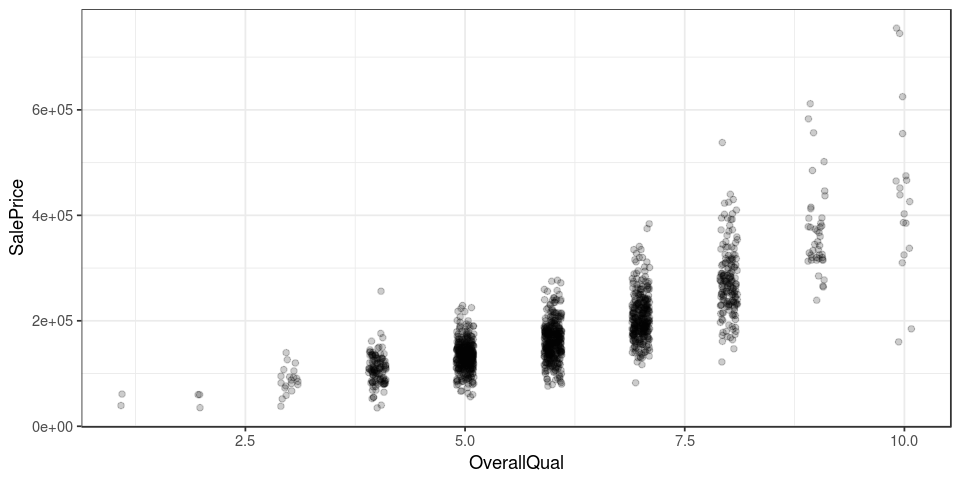

In [71]:
options(repr.plot.width = 8, repr.plot.height = 4)

trainset %>%
    ggplot() +
    geom_jitter(aes(x=OverallQual, y=SalePrice), alpha=0.2, width=0.1, height=0) +
    theme_bw()

In [65]:
?geom_jitter